# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

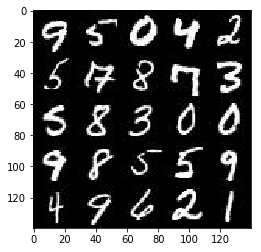

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
import numpy as np
from glob import glob
from matplotlib import pyplot
    
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
images_grid = helper.images_square_grid(mnist_images, 'L')
images_grid = np.asarray(images_grid, dtype=np.uint8)
pyplot.imshow(images_grid, cmap='gray')

#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray',dtype=np.uint8)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

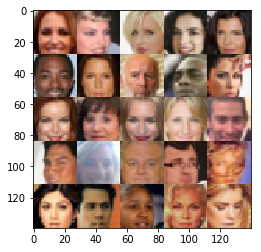

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    #Created a new learning rate variable, input_learning_rate, as it was hitting following error:  
    #You must feed a value for placeholder tensor 'learning_rate' with dtype float
    input_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, input_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        x = tf.maximum(alpha*x, x)
        # output is 14x14x32
        
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        # output is 7x7x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        # output is 4x4x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        # output is 2x2x256
        
        # x = tf.nn.dropout(x, keep_prob=0.5) #Dropout did not improve results
        x = tf.reshape(x, (-1, 2*2*256))
        logits = tf.layers.dense(x, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # x = tf.nn.dropout(z, keep_prob=0.5) #Dropout did not improve results
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1,7,7,512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # output is 7x7x512
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # output is 7x7x256

        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # output is 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # output is 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*alpha))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    #Created separate control_dependencies for discriminator and generator as I was hitting error with discriminator optimizer
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    images_grid = np.asarray(images_grid, dtype=np.uint8)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_learning_rate: learning_rate})
                # Running generator twice did not improve results
                # _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                        "Batch {}...".format(steps),
                        "Discriminator Loss: {:.4f}...".format(d_train_loss),
                        "Generator Loss: {:.4f}...".format(g_train_loss))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.7947... Generator Loss: 0.3932...
Epoch 1/2... Batch 20... Discriminator Loss: 1.7121... Generator Loss: 0.6492...
Epoch 1/2... Batch 30... Discriminator Loss: 1.3463... Generator Loss: 0.7315...
Epoch 1/2... Batch 40... Discriminator Loss: 1.4648... Generator Loss: 0.6341...
Epoch 1/2... Batch 50... Discriminator Loss: 1.6526... Generator Loss: 0.3604...
Epoch 1/2... Batch 60... Discriminator Loss: 1.9229... Generator Loss: 0.2815...
Epoch 1/2... Batch 70... Discriminator Loss: 1.5740... Generator Loss: 0.4114...
Epoch 1/2... Batch 80... Discriminator Loss: 1.4075... Generator Loss: 1.0451...
Epoch 1/2... Batch 90... Discriminator Loss: 1.5256... Generator Loss: 0.6134...
Epoch 1/2... Batch 100... Discriminator Loss: 1.5433... Generator Loss: 0.8238...


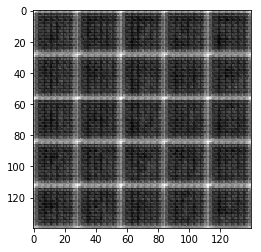

Epoch 1/2... Batch 110... Discriminator Loss: 1.6136... Generator Loss: 0.7823...
Epoch 1/2... Batch 120... Discriminator Loss: 1.3393... Generator Loss: 0.7037...
Epoch 1/2... Batch 130... Discriminator Loss: 1.3892... Generator Loss: 0.5961...
Epoch 1/2... Batch 140... Discriminator Loss: 1.4073... Generator Loss: 0.5500...
Epoch 1/2... Batch 150... Discriminator Loss: 1.3066... Generator Loss: 1.0054...
Epoch 1/2... Batch 160... Discriminator Loss: 1.2392... Generator Loss: 0.8119...
Epoch 1/2... Batch 170... Discriminator Loss: 1.2904... Generator Loss: 0.6861...
Epoch 1/2... Batch 180... Discriminator Loss: 1.2055... Generator Loss: 0.7176...
Epoch 1/2... Batch 190... Discriminator Loss: 1.2723... Generator Loss: 0.7209...
Epoch 1/2... Batch 200... Discriminator Loss: 1.2982... Generator Loss: 0.6124...


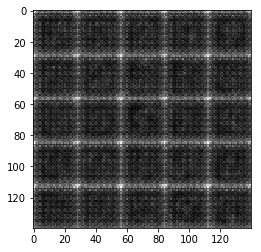

Epoch 1/2... Batch 210... Discriminator Loss: 1.3757... Generator Loss: 0.5214...
Epoch 1/2... Batch 220... Discriminator Loss: 1.1703... Generator Loss: 0.8993...
Epoch 1/2... Batch 230... Discriminator Loss: 1.1847... Generator Loss: 0.7321...
Epoch 1/2... Batch 240... Discriminator Loss: 1.5513... Generator Loss: 0.4200...
Epoch 1/2... Batch 250... Discriminator Loss: 1.0668... Generator Loss: 0.9706...
Epoch 1/2... Batch 260... Discriminator Loss: 1.1094... Generator Loss: 1.5594...
Epoch 1/2... Batch 270... Discriminator Loss: 1.4038... Generator Loss: 0.5147...
Epoch 1/2... Batch 280... Discriminator Loss: 1.2255... Generator Loss: 0.6432...
Epoch 1/2... Batch 290... Discriminator Loss: 1.4101... Generator Loss: 0.4810...
Epoch 1/2... Batch 300... Discriminator Loss: 1.2178... Generator Loss: 0.9738...


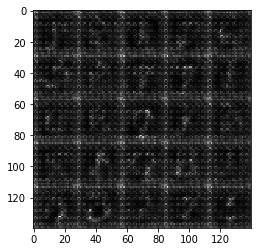

Epoch 1/2... Batch 310... Discriminator Loss: 1.5255... Generator Loss: 0.4394...
Epoch 1/2... Batch 320... Discriminator Loss: 1.1586... Generator Loss: 0.7841...
Epoch 1/2... Batch 330... Discriminator Loss: 1.2831... Generator Loss: 0.6091...
Epoch 1/2... Batch 340... Discriminator Loss: 1.2857... Generator Loss: 0.6582...
Epoch 1/2... Batch 350... Discriminator Loss: 0.9361... Generator Loss: 1.4826...
Epoch 1/2... Batch 360... Discriminator Loss: 1.3990... Generator Loss: 0.4858...
Epoch 1/2... Batch 370... Discriminator Loss: 1.1901... Generator Loss: 0.8172...
Epoch 1/2... Batch 380... Discriminator Loss: 1.1223... Generator Loss: 0.8754...
Epoch 1/2... Batch 390... Discriminator Loss: 1.2228... Generator Loss: 0.8831...
Epoch 1/2... Batch 400... Discriminator Loss: 1.2613... Generator Loss: 0.8831...


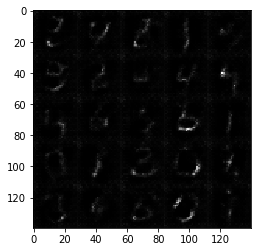

Epoch 1/2... Batch 410... Discriminator Loss: 1.1927... Generator Loss: 0.7152...
Epoch 1/2... Batch 420... Discriminator Loss: 1.1961... Generator Loss: 1.0444...
Epoch 1/2... Batch 430... Discriminator Loss: 1.2698... Generator Loss: 0.8469...
Epoch 1/2... Batch 440... Discriminator Loss: 1.5656... Generator Loss: 0.3963...
Epoch 1/2... Batch 450... Discriminator Loss: 1.3028... Generator Loss: 0.5803...
Epoch 1/2... Batch 460... Discriminator Loss: 1.1952... Generator Loss: 1.0268...
Epoch 1/2... Batch 470... Discriminator Loss: 1.4779... Generator Loss: 0.4763...
Epoch 1/2... Batch 480... Discriminator Loss: 1.2870... Generator Loss: 0.5884...
Epoch 1/2... Batch 490... Discriminator Loss: 1.2144... Generator Loss: 0.6877...
Epoch 1/2... Batch 500... Discriminator Loss: 1.2721... Generator Loss: 0.6413...


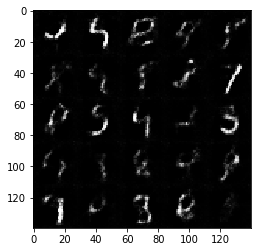

Epoch 1/2... Batch 510... Discriminator Loss: 1.2223... Generator Loss: 0.8353...
Epoch 1/2... Batch 520... Discriminator Loss: 1.1199... Generator Loss: 0.7636...
Epoch 1/2... Batch 530... Discriminator Loss: 1.2675... Generator Loss: 0.6465...
Epoch 1/2... Batch 540... Discriminator Loss: 1.0830... Generator Loss: 1.0781...
Epoch 1/2... Batch 550... Discriminator Loss: 1.1614... Generator Loss: 0.7939...
Epoch 1/2... Batch 560... Discriminator Loss: 1.3651... Generator Loss: 0.5687...
Epoch 1/2... Batch 570... Discriminator Loss: 1.3649... Generator Loss: 0.5894...
Epoch 1/2... Batch 580... Discriminator Loss: 1.3499... Generator Loss: 0.5924...
Epoch 1/2... Batch 590... Discriminator Loss: 1.2328... Generator Loss: 0.7027...
Epoch 1/2... Batch 600... Discriminator Loss: 1.2134... Generator Loss: 0.6602...


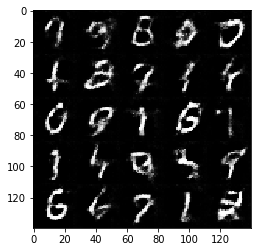

Epoch 1/2... Batch 610... Discriminator Loss: 1.3793... Generator Loss: 1.4797...
Epoch 1/2... Batch 620... Discriminator Loss: 1.4356... Generator Loss: 0.4695...
Epoch 1/2... Batch 630... Discriminator Loss: 1.2357... Generator Loss: 1.1514...
Epoch 1/2... Batch 640... Discriminator Loss: 1.2440... Generator Loss: 0.8011...
Epoch 1/2... Batch 650... Discriminator Loss: 1.1887... Generator Loss: 0.7672...
Epoch 1/2... Batch 660... Discriminator Loss: 1.3366... Generator Loss: 0.6073...
Epoch 1/2... Batch 670... Discriminator Loss: 1.4980... Generator Loss: 0.4230...
Epoch 1/2... Batch 680... Discriminator Loss: 1.5396... Generator Loss: 0.4028...
Epoch 1/2... Batch 690... Discriminator Loss: 1.1978... Generator Loss: 0.7557...
Epoch 1/2... Batch 700... Discriminator Loss: 1.5199... Generator Loss: 0.4382...


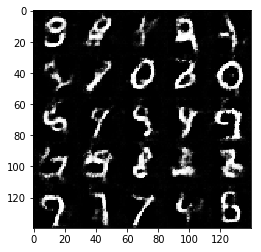

Epoch 1/2... Batch 710... Discriminator Loss: 1.5537... Generator Loss: 0.3997...
Epoch 1/2... Batch 720... Discriminator Loss: 1.5735... Generator Loss: 0.3964...
Epoch 1/2... Batch 730... Discriminator Loss: 1.1815... Generator Loss: 0.8500...
Epoch 1/2... Batch 740... Discriminator Loss: 1.3483... Generator Loss: 0.6330...
Epoch 1/2... Batch 750... Discriminator Loss: 1.2007... Generator Loss: 1.3251...
Epoch 1/2... Batch 760... Discriminator Loss: 1.4183... Generator Loss: 0.5130...
Epoch 1/2... Batch 770... Discriminator Loss: 1.1658... Generator Loss: 0.7172...
Epoch 1/2... Batch 780... Discriminator Loss: 1.2272... Generator Loss: 0.7873...
Epoch 1/2... Batch 790... Discriminator Loss: 1.3833... Generator Loss: 0.5004...
Epoch 1/2... Batch 800... Discriminator Loss: 1.3648... Generator Loss: 0.5351...


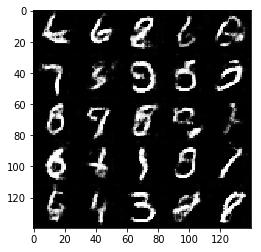

Epoch 1/2... Batch 810... Discriminator Loss: 1.2014... Generator Loss: 0.9274...
Epoch 1/2... Batch 820... Discriminator Loss: 1.2649... Generator Loss: 0.6388...
Epoch 1/2... Batch 830... Discriminator Loss: 1.2410... Generator Loss: 0.8145...
Epoch 1/2... Batch 840... Discriminator Loss: 1.2706... Generator Loss: 0.6265...
Epoch 1/2... Batch 850... Discriminator Loss: 1.2224... Generator Loss: 0.6770...
Epoch 1/2... Batch 860... Discriminator Loss: 1.1397... Generator Loss: 0.9192...
Epoch 1/2... Batch 870... Discriminator Loss: 1.2066... Generator Loss: 0.9641...
Epoch 1/2... Batch 880... Discriminator Loss: 1.3650... Generator Loss: 0.5120...
Epoch 1/2... Batch 890... Discriminator Loss: 1.4315... Generator Loss: 0.4803...
Epoch 1/2... Batch 900... Discriminator Loss: 1.1736... Generator Loss: 0.9377...


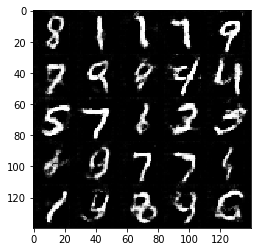

Epoch 1/2... Batch 910... Discriminator Loss: 1.1597... Generator Loss: 0.7995...
Epoch 1/2... Batch 920... Discriminator Loss: 1.3011... Generator Loss: 0.6185...
Epoch 1/2... Batch 930... Discriminator Loss: 1.2308... Generator Loss: 0.6431...
Epoch 2/2... Batch 940... Discriminator Loss: 1.4427... Generator Loss: 0.4815...
Epoch 2/2... Batch 950... Discriminator Loss: 1.1553... Generator Loss: 0.8797...
Epoch 2/2... Batch 960... Discriminator Loss: 1.2490... Generator Loss: 0.7535...
Epoch 2/2... Batch 970... Discriminator Loss: 1.1002... Generator Loss: 1.0023...
Epoch 2/2... Batch 980... Discriminator Loss: 1.2901... Generator Loss: 0.6875...
Epoch 2/2... Batch 990... Discriminator Loss: 1.1923... Generator Loss: 0.9218...
Epoch 2/2... Batch 1000... Discriminator Loss: 1.2574... Generator Loss: 0.8130...


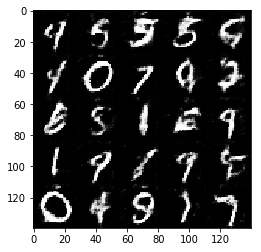

Epoch 2/2... Batch 1010... Discriminator Loss: 1.2684... Generator Loss: 0.6560...
Epoch 2/2... Batch 1020... Discriminator Loss: 1.5739... Generator Loss: 0.4010...
Epoch 2/2... Batch 1030... Discriminator Loss: 1.3739... Generator Loss: 0.6013...
Epoch 2/2... Batch 1040... Discriminator Loss: 1.3149... Generator Loss: 0.5419...
Epoch 2/2... Batch 1050... Discriminator Loss: 1.3980... Generator Loss: 0.5121...
Epoch 2/2... Batch 1060... Discriminator Loss: 1.3655... Generator Loss: 0.5474...
Epoch 2/2... Batch 1070... Discriminator Loss: 1.1996... Generator Loss: 1.1178...
Epoch 2/2... Batch 1080... Discriminator Loss: 1.1781... Generator Loss: 0.7558...
Epoch 2/2... Batch 1090... Discriminator Loss: 1.2634... Generator Loss: 0.6134...
Epoch 2/2... Batch 1100... Discriminator Loss: 1.1326... Generator Loss: 0.8253...


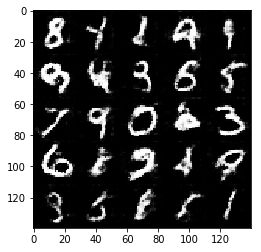

Epoch 2/2... Batch 1110... Discriminator Loss: 1.1694... Generator Loss: 1.1007...
Epoch 2/2... Batch 1120... Discriminator Loss: 1.1791... Generator Loss: 0.7165...
Epoch 2/2... Batch 1130... Discriminator Loss: 1.3316... Generator Loss: 0.5815...
Epoch 2/2... Batch 1140... Discriminator Loss: 1.5197... Generator Loss: 0.4479...
Epoch 2/2... Batch 1150... Discriminator Loss: 1.2435... Generator Loss: 0.7878...
Epoch 2/2... Batch 1160... Discriminator Loss: 1.1604... Generator Loss: 1.0036...
Epoch 2/2... Batch 1170... Discriminator Loss: 1.3607... Generator Loss: 0.5435...
Epoch 2/2... Batch 1180... Discriminator Loss: 1.3198... Generator Loss: 0.5575...
Epoch 2/2... Batch 1190... Discriminator Loss: 1.2677... Generator Loss: 0.8027...
Epoch 2/2... Batch 1200... Discriminator Loss: 1.7788... Generator Loss: 0.3118...


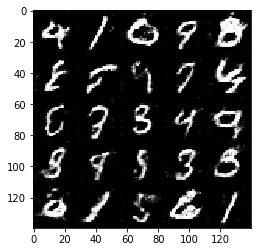

Epoch 2/2... Batch 1210... Discriminator Loss: 1.3488... Generator Loss: 0.5869...
Epoch 2/2... Batch 1220... Discriminator Loss: 1.2808... Generator Loss: 0.9892...
Epoch 2/2... Batch 1230... Discriminator Loss: 1.4258... Generator Loss: 0.4872...
Epoch 2/2... Batch 1240... Discriminator Loss: 1.1470... Generator Loss: 0.8661...
Epoch 2/2... Batch 1250... Discriminator Loss: 1.2553... Generator Loss: 0.7632...
Epoch 2/2... Batch 1260... Discriminator Loss: 1.3855... Generator Loss: 1.6933...
Epoch 2/2... Batch 1270... Discriminator Loss: 1.5409... Generator Loss: 0.4240...
Epoch 2/2... Batch 1280... Discriminator Loss: 1.2293... Generator Loss: 0.6659...
Epoch 2/2... Batch 1290... Discriminator Loss: 1.6532... Generator Loss: 0.3401...
Epoch 2/2... Batch 1300... Discriminator Loss: 1.3491... Generator Loss: 0.5134...


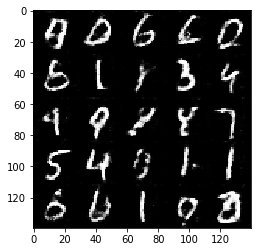

Epoch 2/2... Batch 1310... Discriminator Loss: 1.7692... Generator Loss: 0.3133...
Epoch 2/2... Batch 1320... Discriminator Loss: 1.4186... Generator Loss: 0.5790...
Epoch 2/2... Batch 1330... Discriminator Loss: 1.3724... Generator Loss: 0.5080...
Epoch 2/2... Batch 1340... Discriminator Loss: 1.1477... Generator Loss: 1.3844...
Epoch 2/2... Batch 1350... Discriminator Loss: 1.2061... Generator Loss: 0.6643...
Epoch 2/2... Batch 1360... Discriminator Loss: 1.1183... Generator Loss: 1.2688...
Epoch 2/2... Batch 1370... Discriminator Loss: 1.1454... Generator Loss: 0.9370...
Epoch 2/2... Batch 1380... Discriminator Loss: 1.4417... Generator Loss: 0.4934...
Epoch 2/2... Batch 1390... Discriminator Loss: 1.2156... Generator Loss: 1.0310...
Epoch 2/2... Batch 1400... Discriminator Loss: 1.3611... Generator Loss: 0.5256...


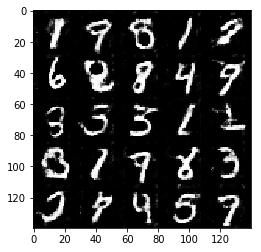

Epoch 2/2... Batch 1410... Discriminator Loss: 1.3985... Generator Loss: 0.5955...
Epoch 2/2... Batch 1420... Discriminator Loss: 1.2720... Generator Loss: 0.6394...
Epoch 2/2... Batch 1430... Discriminator Loss: 1.1694... Generator Loss: 0.7510...
Epoch 2/2... Batch 1440... Discriminator Loss: 1.1401... Generator Loss: 0.8293...
Epoch 2/2... Batch 1450... Discriminator Loss: 1.3929... Generator Loss: 0.4932...
Epoch 2/2... Batch 1460... Discriminator Loss: 1.2122... Generator Loss: 0.6148...
Epoch 2/2... Batch 1470... Discriminator Loss: 1.4212... Generator Loss: 0.4941...
Epoch 2/2... Batch 1480... Discriminator Loss: 1.1613... Generator Loss: 0.7598...
Epoch 2/2... Batch 1490... Discriminator Loss: 1.4157... Generator Loss: 0.4708...
Epoch 2/2... Batch 1500... Discriminator Loss: 1.1917... Generator Loss: 0.7508...


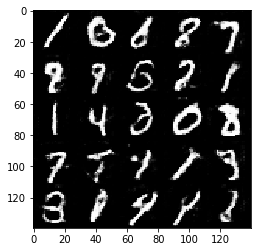

Epoch 2/2... Batch 1510... Discriminator Loss: 1.3850... Generator Loss: 0.5341...
Epoch 2/2... Batch 1520... Discriminator Loss: 1.2871... Generator Loss: 0.5791...
Epoch 2/2... Batch 1530... Discriminator Loss: 1.5603... Generator Loss: 0.4071...
Epoch 2/2... Batch 1540... Discriminator Loss: 1.2066... Generator Loss: 0.7350...
Epoch 2/2... Batch 1550... Discriminator Loss: 1.0094... Generator Loss: 0.9357...
Epoch 2/2... Batch 1560... Discriminator Loss: 1.3963... Generator Loss: 0.4833...
Epoch 2/2... Batch 1570... Discriminator Loss: 0.9480... Generator Loss: 1.2238...
Epoch 2/2... Batch 1580... Discriminator Loss: 1.0150... Generator Loss: 1.0615...
Epoch 2/2... Batch 1590... Discriminator Loss: 1.2322... Generator Loss: 0.6925...
Epoch 2/2... Batch 1600... Discriminator Loss: 1.2361... Generator Loss: 0.6782...


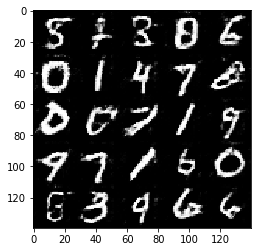

Epoch 2/2... Batch 1610... Discriminator Loss: 1.8192... Generator Loss: 0.2962...
Epoch 2/2... Batch 1620... Discriminator Loss: 1.1851... Generator Loss: 0.6769...
Epoch 2/2... Batch 1630... Discriminator Loss: 1.3501... Generator Loss: 0.6550...
Epoch 2/2... Batch 1640... Discriminator Loss: 1.5636... Generator Loss: 0.3956...
Epoch 2/2... Batch 1650... Discriminator Loss: 1.3147... Generator Loss: 0.5749...
Epoch 2/2... Batch 1660... Discriminator Loss: 1.3496... Generator Loss: 1.7514...
Epoch 2/2... Batch 1670... Discriminator Loss: 1.1794... Generator Loss: 0.7060...
Epoch 2/2... Batch 1680... Discriminator Loss: 1.1615... Generator Loss: 0.6565...
Epoch 2/2... Batch 1690... Discriminator Loss: 1.1241... Generator Loss: 0.7294...
Epoch 2/2... Batch 1700... Discriminator Loss: 1.1036... Generator Loss: 1.1197...


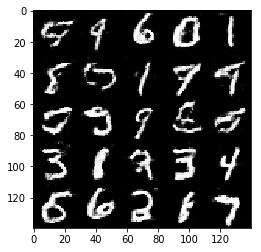

Epoch 2/2... Batch 1710... Discriminator Loss: 1.1349... Generator Loss: 0.9203...
Epoch 2/2... Batch 1720... Discriminator Loss: 1.3511... Generator Loss: 0.5557...
Epoch 2/2... Batch 1730... Discriminator Loss: 1.5714... Generator Loss: 0.4147...
Epoch 2/2... Batch 1740... Discriminator Loss: 1.3223... Generator Loss: 0.6183...
Epoch 2/2... Batch 1750... Discriminator Loss: 1.2654... Generator Loss: 0.9104...
Epoch 2/2... Batch 1760... Discriminator Loss: 1.1423... Generator Loss: 1.3155...
Epoch 2/2... Batch 1770... Discriminator Loss: 1.1755... Generator Loss: 0.6957...
Epoch 2/2... Batch 1780... Discriminator Loss: 1.3743... Generator Loss: 1.7955...
Epoch 2/2... Batch 1790... Discriminator Loss: 1.5392... Generator Loss: 0.4148...
Epoch 2/2... Batch 1800... Discriminator Loss: 1.2837... Generator Loss: 1.0844...


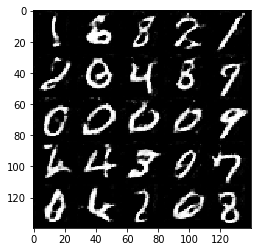

Epoch 2/2... Batch 1810... Discriminator Loss: 1.4343... Generator Loss: 0.5504...
Epoch 2/2... Batch 1820... Discriminator Loss: 1.1506... Generator Loss: 0.8400...
Epoch 2/2... Batch 1830... Discriminator Loss: 1.1015... Generator Loss: 0.8256...
Epoch 2/2... Batch 1840... Discriminator Loss: 0.9918... Generator Loss: 1.1694...
Epoch 2/2... Batch 1850... Discriminator Loss: 1.0534... Generator Loss: 0.8956...
Epoch 2/2... Batch 1860... Discriminator Loss: 1.2084... Generator Loss: 0.7144...
Epoch 2/2... Batch 1870... Discriminator Loss: 1.9511... Generator Loss: 0.2694...


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.9738... Generator Loss: 0.2937...
Epoch 1/1... Batch 20... Discriminator Loss: 1.7108... Generator Loss: 0.3696...
Epoch 1/1... Batch 30... Discriminator Loss: 1.2600... Generator Loss: 0.9038...
Epoch 1/1... Batch 40... Discriminator Loss: 1.0556... Generator Loss: 0.8008...
Epoch 1/1... Batch 50... Discriminator Loss: 1.2458... Generator Loss: 0.6156...
Epoch 1/1... Batch 60... Discriminator Loss: 1.2856... Generator Loss: 0.6444...
Epoch 1/1... Batch 70... Discriminator Loss: 1.5446... Generator Loss: 0.5104...
Epoch 1/1... Batch 80... Discriminator Loss: 1.1545... Generator Loss: 0.7173...
Epoch 1/1... Batch 90... Discriminator Loss: 1.5194... Generator Loss: 2.0814...
Epoch 1/1... Batch 100... Discriminator Loss: 1.3432... Generator Loss: 0.8746...


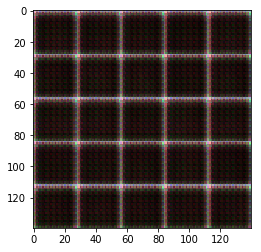

Epoch 1/1... Batch 110... Discriminator Loss: 1.4691... Generator Loss: 1.3951...
Epoch 1/1... Batch 120... Discriminator Loss: 1.5395... Generator Loss: 0.5873...
Epoch 1/1... Batch 130... Discriminator Loss: 1.5456... Generator Loss: 0.4715...
Epoch 1/1... Batch 140... Discriminator Loss: 1.5132... Generator Loss: 0.5710...
Epoch 1/1... Batch 150... Discriminator Loss: 1.4457... Generator Loss: 0.4934...
Epoch 1/1... Batch 160... Discriminator Loss: 1.3837... Generator Loss: 0.6516...
Epoch 1/1... Batch 170... Discriminator Loss: 1.2675... Generator Loss: 0.7326...
Epoch 1/1... Batch 180... Discriminator Loss: 1.2247... Generator Loss: 0.8595...
Epoch 1/1... Batch 190... Discriminator Loss: 1.3770... Generator Loss: 0.6280...
Epoch 1/1... Batch 200... Discriminator Loss: 1.2830... Generator Loss: 0.6838...


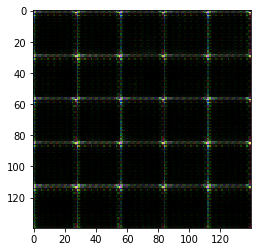

Epoch 1/1... Batch 210... Discriminator Loss: 1.0519... Generator Loss: 0.9696...
Epoch 1/1... Batch 220... Discriminator Loss: 1.5785... Generator Loss: 0.4242...
Epoch 1/1... Batch 230... Discriminator Loss: 1.4560... Generator Loss: 0.5372...
Epoch 1/1... Batch 240... Discriminator Loss: 1.3199... Generator Loss: 0.7516...
Epoch 1/1... Batch 250... Discriminator Loss: 1.3952... Generator Loss: 0.6254...
Epoch 1/1... Batch 260... Discriminator Loss: 1.5116... Generator Loss: 0.5596...
Epoch 1/1... Batch 270... Discriminator Loss: 1.7412... Generator Loss: 0.3247...
Epoch 1/1... Batch 280... Discriminator Loss: 1.3773... Generator Loss: 0.6549...
Epoch 1/1... Batch 290... Discriminator Loss: 1.2758... Generator Loss: 0.7101...
Epoch 1/1... Batch 300... Discriminator Loss: 1.2735... Generator Loss: 0.7587...


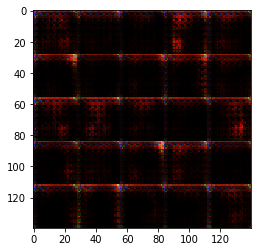

Epoch 1/1... Batch 310... Discriminator Loss: 1.3605... Generator Loss: 0.9670...
Epoch 1/1... Batch 320... Discriminator Loss: 1.2905... Generator Loss: 1.0006...
Epoch 1/1... Batch 330... Discriminator Loss: 1.3513... Generator Loss: 0.7352...
Epoch 1/1... Batch 340... Discriminator Loss: 1.2642... Generator Loss: 0.9545...
Epoch 1/1... Batch 350... Discriminator Loss: 1.2311... Generator Loss: 0.8852...
Epoch 1/1... Batch 360... Discriminator Loss: 1.5024... Generator Loss: 0.6269...
Epoch 1/1... Batch 370... Discriminator Loss: 1.3580... Generator Loss: 0.8584...
Epoch 1/1... Batch 380... Discriminator Loss: 1.4137... Generator Loss: 0.6759...
Epoch 1/1... Batch 390... Discriminator Loss: 1.4347... Generator Loss: 0.7352...
Epoch 1/1... Batch 400... Discriminator Loss: 1.3670... Generator Loss: 0.7383...


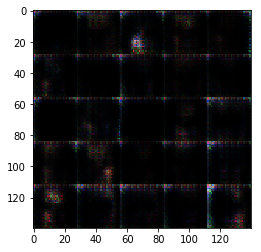

Epoch 1/1... Batch 410... Discriminator Loss: 1.3028... Generator Loss: 0.7402...
Epoch 1/1... Batch 420... Discriminator Loss: 1.3557... Generator Loss: 0.7182...
Epoch 1/1... Batch 430... Discriminator Loss: 1.4360... Generator Loss: 0.7253...
Epoch 1/1... Batch 440... Discriminator Loss: 1.3647... Generator Loss: 0.8220...
Epoch 1/1... Batch 450... Discriminator Loss: 1.4084... Generator Loss: 0.6333...
Epoch 1/1... Batch 460... Discriminator Loss: 1.3998... Generator Loss: 0.7218...
Epoch 1/1... Batch 470... Discriminator Loss: 1.2972... Generator Loss: 0.7540...
Epoch 1/1... Batch 480... Discriminator Loss: 1.3569... Generator Loss: 0.7845...
Epoch 1/1... Batch 490... Discriminator Loss: 1.4427... Generator Loss: 0.6052...
Epoch 1/1... Batch 500... Discriminator Loss: 1.3554... Generator Loss: 0.7624...


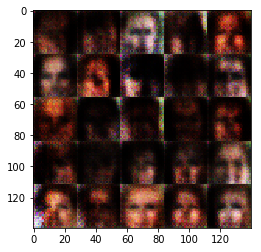

Epoch 1/1... Batch 510... Discriminator Loss: 1.4107... Generator Loss: 0.7242...
Epoch 1/1... Batch 520... Discriminator Loss: 1.4401... Generator Loss: 0.6905...
Epoch 1/1... Batch 530... Discriminator Loss: 1.3322... Generator Loss: 0.8153...
Epoch 1/1... Batch 540... Discriminator Loss: 1.3937... Generator Loss: 0.6987...
Epoch 1/1... Batch 550... Discriminator Loss: 1.4046... Generator Loss: 0.7761...
Epoch 1/1... Batch 560... Discriminator Loss: 1.3675... Generator Loss: 0.7074...
Epoch 1/1... Batch 570... Discriminator Loss: 1.3101... Generator Loss: 0.7989...
Epoch 1/1... Batch 580... Discriminator Loss: 1.3840... Generator Loss: 0.7170...
Epoch 1/1... Batch 590... Discriminator Loss: 1.3384... Generator Loss: 0.7172...
Epoch 1/1... Batch 600... Discriminator Loss: 1.3688... Generator Loss: 0.7188...


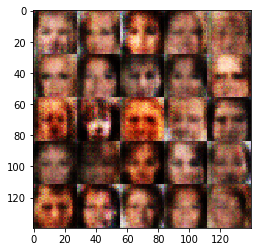

Epoch 1/1... Batch 610... Discriminator Loss: 1.3339... Generator Loss: 0.7611...
Epoch 1/1... Batch 620... Discriminator Loss: 1.4582... Generator Loss: 0.7440...
Epoch 1/1... Batch 630... Discriminator Loss: 1.3533... Generator Loss: 0.7404...
Epoch 1/1... Batch 640... Discriminator Loss: 1.4094... Generator Loss: 0.6734...
Epoch 1/1... Batch 650... Discriminator Loss: 1.3142... Generator Loss: 0.7028...
Epoch 1/1... Batch 660... Discriminator Loss: 1.4564... Generator Loss: 0.7777...
Epoch 1/1... Batch 670... Discriminator Loss: 1.2798... Generator Loss: 0.7894...
Epoch 1/1... Batch 680... Discriminator Loss: 1.3762... Generator Loss: 0.6898...
Epoch 1/1... Batch 690... Discriminator Loss: 1.4120... Generator Loss: 0.7256...
Epoch 1/1... Batch 700... Discriminator Loss: 1.3528... Generator Loss: 0.7419...


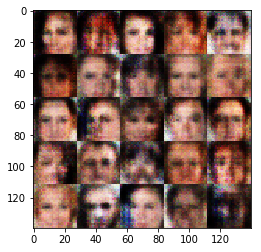

Epoch 1/1... Batch 710... Discriminator Loss: 1.3665... Generator Loss: 0.6938...
Epoch 1/1... Batch 720... Discriminator Loss: 1.3811... Generator Loss: 0.7306...
Epoch 1/1... Batch 730... Discriminator Loss: 1.4427... Generator Loss: 0.7019...
Epoch 1/1... Batch 740... Discriminator Loss: 1.3045... Generator Loss: 0.7745...
Epoch 1/1... Batch 750... Discriminator Loss: 1.3341... Generator Loss: 0.7075...
Epoch 1/1... Batch 760... Discriminator Loss: 1.3530... Generator Loss: 0.7349...
Epoch 1/1... Batch 770... Discriminator Loss: 1.3713... Generator Loss: 0.7019...
Epoch 1/1... Batch 780... Discriminator Loss: 1.3280... Generator Loss: 0.8271...
Epoch 1/1... Batch 790... Discriminator Loss: 1.4096... Generator Loss: 0.7047...
Epoch 1/1... Batch 800... Discriminator Loss: 1.2659... Generator Loss: 0.8475...


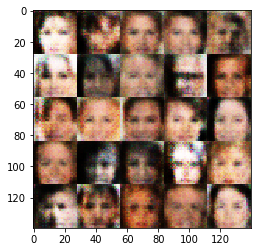

Epoch 1/1... Batch 810... Discriminator Loss: 1.3398... Generator Loss: 0.7047...
Epoch 1/1... Batch 820... Discriminator Loss: 1.2782... Generator Loss: 0.8507...
Epoch 1/1... Batch 830... Discriminator Loss: 1.3188... Generator Loss: 0.7626...
Epoch 1/1... Batch 840... Discriminator Loss: 1.3705... Generator Loss: 0.6957...
Epoch 1/1... Batch 850... Discriminator Loss: 1.1913... Generator Loss: 0.8132...
Epoch 1/1... Batch 860... Discriminator Loss: 1.6020... Generator Loss: 0.3953...
Epoch 1/1... Batch 870... Discriminator Loss: 1.3419... Generator Loss: 0.7417...
Epoch 1/1... Batch 880... Discriminator Loss: 1.1864... Generator Loss: 0.8233...
Epoch 1/1... Batch 890... Discriminator Loss: 1.0917... Generator Loss: 0.8873...
Epoch 1/1... Batch 900... Discriminator Loss: 1.0852... Generator Loss: 0.9580...


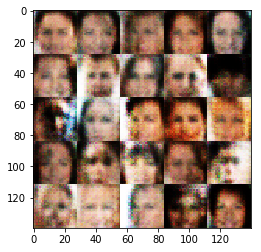

Epoch 1/1... Batch 910... Discriminator Loss: 1.3200... Generator Loss: 0.7154...
Epoch 1/1... Batch 920... Discriminator Loss: 1.0525... Generator Loss: 1.5653...
Epoch 1/1... Batch 930... Discriminator Loss: 1.1900... Generator Loss: 2.3753...
Epoch 1/1... Batch 940... Discriminator Loss: 1.2897... Generator Loss: 0.8232...
Epoch 1/1... Batch 950... Discriminator Loss: 1.2510... Generator Loss: 0.6937...
Epoch 1/1... Batch 960... Discriminator Loss: 0.7704... Generator Loss: 2.2456...
Epoch 1/1... Batch 970... Discriminator Loss: 1.2403... Generator Loss: 0.9543...
Epoch 1/1... Batch 980... Discriminator Loss: 1.2745... Generator Loss: 0.5928...
Epoch 1/1... Batch 990... Discriminator Loss: 1.2270... Generator Loss: 0.7672...
Epoch 1/1... Batch 1000... Discriminator Loss: 1.0923... Generator Loss: 1.2897...


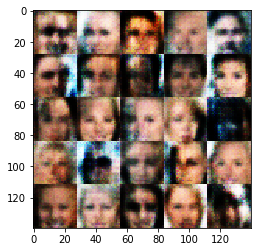

Epoch 1/1... Batch 1010... Discriminator Loss: 1.3447... Generator Loss: 0.9883...
Epoch 1/1... Batch 1020... Discriminator Loss: 1.1829... Generator Loss: 1.3297...
Epoch 1/1... Batch 1030... Discriminator Loss: 1.3204... Generator Loss: 2.8720...
Epoch 1/1... Batch 1040... Discriminator Loss: 1.0540... Generator Loss: 0.7732...
Epoch 1/1... Batch 1050... Discriminator Loss: 0.9147... Generator Loss: 1.3848...
Epoch 1/1... Batch 1060... Discriminator Loss: 1.2853... Generator Loss: 1.3630...
Epoch 1/1... Batch 1070... Discriminator Loss: 0.9787... Generator Loss: 1.3982...
Epoch 1/1... Batch 1080... Discriminator Loss: 0.9035... Generator Loss: 1.1478...
Epoch 1/1... Batch 1090... Discriminator Loss: 0.8002... Generator Loss: 1.1933...
Epoch 1/1... Batch 1100... Discriminator Loss: 1.1483... Generator Loss: 1.2041...


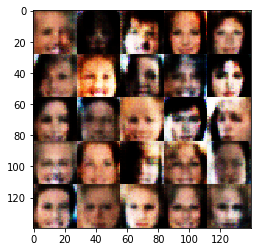

Epoch 1/1... Batch 1110... Discriminator Loss: 0.9233... Generator Loss: 2.3665...
Epoch 1/1... Batch 1120... Discriminator Loss: 0.9632... Generator Loss: 0.8907...
Epoch 1/1... Batch 1130... Discriminator Loss: 1.2116... Generator Loss: 0.6536...
Epoch 1/1... Batch 1140... Discriminator Loss: 0.7656... Generator Loss: 1.7671...
Epoch 1/1... Batch 1150... Discriminator Loss: 0.6455... Generator Loss: 2.5307...
Epoch 1/1... Batch 1160... Discriminator Loss: 1.2786... Generator Loss: 0.8925...
Epoch 1/1... Batch 1170... Discriminator Loss: 0.6851... Generator Loss: 1.8384...
Epoch 1/1... Batch 1180... Discriminator Loss: 0.9412... Generator Loss: 0.9052...
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1052... Generator Loss: 0.7395...
Epoch 1/1... Batch 1200... Discriminator Loss: 1.1623... Generator Loss: 0.8477...


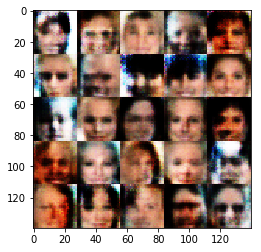

Epoch 1/1... Batch 1210... Discriminator Loss: 0.6555... Generator Loss: 2.3236...
Epoch 1/1... Batch 1220... Discriminator Loss: 0.9330... Generator Loss: 0.9178...
Epoch 1/1... Batch 1230... Discriminator Loss: 0.7582... Generator Loss: 1.4769...
Epoch 1/1... Batch 1240... Discriminator Loss: 0.8567... Generator Loss: 1.1961...
Epoch 1/1... Batch 1250... Discriminator Loss: 1.2279... Generator Loss: 0.5936...
Epoch 1/1... Batch 1260... Discriminator Loss: 0.6098... Generator Loss: 2.2590...
Epoch 1/1... Batch 1270... Discriminator Loss: 1.2836... Generator Loss: 2.7924...
Epoch 1/1... Batch 1280... Discriminator Loss: 1.5529... Generator Loss: 0.3894...
Epoch 1/1... Batch 1290... Discriminator Loss: 0.7866... Generator Loss: 1.3235...
Epoch 1/1... Batch 1300... Discriminator Loss: 0.7269... Generator Loss: 2.4549...


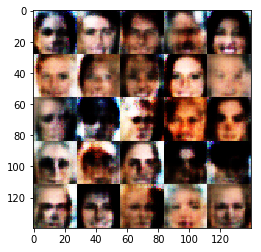

Epoch 1/1... Batch 1310... Discriminator Loss: 1.3336... Generator Loss: 0.8547...
Epoch 1/1... Batch 1320... Discriminator Loss: 0.6978... Generator Loss: 1.6855...
Epoch 1/1... Batch 1330... Discriminator Loss: 1.0220... Generator Loss: 3.0497...
Epoch 1/1... Batch 1340... Discriminator Loss: 0.7142... Generator Loss: 2.0285...
Epoch 1/1... Batch 1350... Discriminator Loss: 0.8980... Generator Loss: 2.0684...
Epoch 1/1... Batch 1360... Discriminator Loss: 1.0081... Generator Loss: 1.2073...
Epoch 1/1... Batch 1370... Discriminator Loss: 1.4538... Generator Loss: 0.8955...
Epoch 1/1... Batch 1380... Discriminator Loss: 0.7335... Generator Loss: 1.7817...
Epoch 1/1... Batch 1390... Discriminator Loss: 0.8496... Generator Loss: 1.1801...
Epoch 1/1... Batch 1400... Discriminator Loss: 0.6210... Generator Loss: 2.6596...


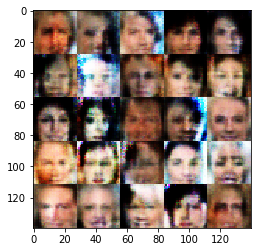

Epoch 1/1... Batch 1410... Discriminator Loss: 0.9829... Generator Loss: 0.8529...
Epoch 1/1... Batch 1420... Discriminator Loss: 1.2092... Generator Loss: 1.5661...
Epoch 1/1... Batch 1430... Discriminator Loss: 1.0595... Generator Loss: 0.8988...
Epoch 1/1... Batch 1440... Discriminator Loss: 0.7188... Generator Loss: 1.5971...
Epoch 1/1... Batch 1450... Discriminator Loss: 0.7310... Generator Loss: 1.5363...
Epoch 1/1... Batch 1460... Discriminator Loss: 0.7250... Generator Loss: 2.1403...
Epoch 1/1... Batch 1470... Discriminator Loss: 0.6965... Generator Loss: 1.6594...
Epoch 1/1... Batch 1480... Discriminator Loss: 0.6485... Generator Loss: 2.4269...
Epoch 1/1... Batch 1490... Discriminator Loss: 1.6524... Generator Loss: 0.3410...
Epoch 1/1... Batch 1500... Discriminator Loss: 0.7045... Generator Loss: 2.6905...


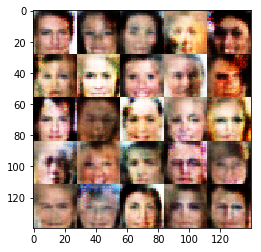

Epoch 1/1... Batch 1510... Discriminator Loss: 0.7595... Generator Loss: 1.4064...
Epoch 1/1... Batch 1520... Discriminator Loss: 1.0276... Generator Loss: 1.9461...
Epoch 1/1... Batch 1530... Discriminator Loss: 0.8893... Generator Loss: 1.8037...
Epoch 1/1... Batch 1540... Discriminator Loss: 1.1507... Generator Loss: 0.7316...
Epoch 1/1... Batch 1550... Discriminator Loss: 0.7568... Generator Loss: 1.6767...
Epoch 1/1... Batch 1560... Discriminator Loss: 0.7524... Generator Loss: 1.3471...
Epoch 1/1... Batch 1570... Discriminator Loss: 0.9193... Generator Loss: 3.5924...
Epoch 1/1... Batch 1580... Discriminator Loss: 0.8865... Generator Loss: 1.8364...
Epoch 1/1... Batch 1590... Discriminator Loss: 0.7800... Generator Loss: 1.6096...
Epoch 1/1... Batch 1600... Discriminator Loss: 1.0495... Generator Loss: 0.8360...


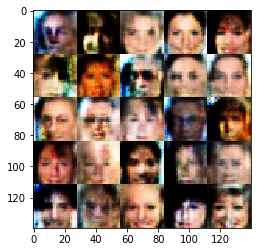

Epoch 1/1... Batch 1610... Discriminator Loss: 0.6497... Generator Loss: 2.5493...
Epoch 1/1... Batch 1620... Discriminator Loss: 0.5599... Generator Loss: 2.4832...
Epoch 1/1... Batch 1630... Discriminator Loss: 1.2470... Generator Loss: 0.6604...
Epoch 1/1... Batch 1640... Discriminator Loss: 0.7843... Generator Loss: 1.8970...
Epoch 1/1... Batch 1650... Discriminator Loss: 0.7730... Generator Loss: 1.5979...
Epoch 1/1... Batch 1660... Discriminator Loss: 0.8951... Generator Loss: 1.0753...
Epoch 1/1... Batch 1670... Discriminator Loss: 0.7467... Generator Loss: 1.8878...
Epoch 1/1... Batch 1680... Discriminator Loss: 0.6680... Generator Loss: 2.2528...
Epoch 1/1... Batch 1690... Discriminator Loss: 0.7865... Generator Loss: 1.6606...
Epoch 1/1... Batch 1700... Discriminator Loss: 0.7113... Generator Loss: 1.5985...


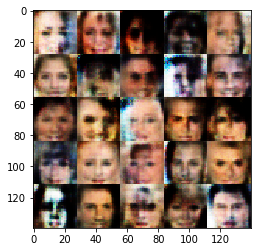

Epoch 1/1... Batch 1710... Discriminator Loss: 0.9228... Generator Loss: 1.0511...
Epoch 1/1... Batch 1720... Discriminator Loss: 1.1094... Generator Loss: 0.8502...
Epoch 1/1... Batch 1730... Discriminator Loss: 0.7133... Generator Loss: 1.6457...
Epoch 1/1... Batch 1740... Discriminator Loss: 0.6422... Generator Loss: 1.8740...
Epoch 1/1... Batch 1750... Discriminator Loss: 0.7522... Generator Loss: 1.6737...
Epoch 1/1... Batch 1760... Discriminator Loss: 1.0804... Generator Loss: 0.8770...
Epoch 1/1... Batch 1770... Discriminator Loss: 1.3029... Generator Loss: 0.5493...
Epoch 1/1... Batch 1780... Discriminator Loss: 1.0804... Generator Loss: 0.7811...
Epoch 1/1... Batch 1790... Discriminator Loss: 0.5537... Generator Loss: 2.3932...
Epoch 1/1... Batch 1800... Discriminator Loss: 0.7419... Generator Loss: 1.5384...


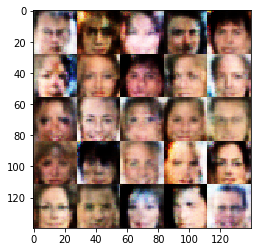

Epoch 1/1... Batch 1810... Discriminator Loss: 1.1688... Generator Loss: 0.8458...
Epoch 1/1... Batch 1820... Discriminator Loss: 0.6499... Generator Loss: 2.1354...
Epoch 1/1... Batch 1830... Discriminator Loss: 0.9622... Generator Loss: 0.9729...
Epoch 1/1... Batch 1840... Discriminator Loss: 0.7902... Generator Loss: 1.1832...
Epoch 1/1... Batch 1850... Discriminator Loss: 0.7677... Generator Loss: 2.0649...
Epoch 1/1... Batch 1860... Discriminator Loss: 0.9278... Generator Loss: 1.6328...
Epoch 1/1... Batch 1870... Discriminator Loss: 0.8113... Generator Loss: 2.5488...
Epoch 1/1... Batch 1880... Discriminator Loss: 1.2708... Generator Loss: 0.6145...
Epoch 1/1... Batch 1890... Discriminator Loss: 0.7971... Generator Loss: 1.6975...
Epoch 1/1... Batch 1900... Discriminator Loss: 0.7874... Generator Loss: 1.5099...


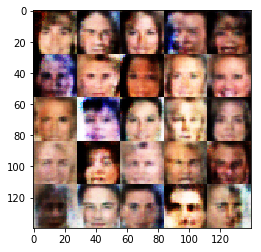

Epoch 1/1... Batch 1910... Discriminator Loss: 0.7095... Generator Loss: 1.4722...
Epoch 1/1... Batch 1920... Discriminator Loss: 0.6527... Generator Loss: 2.4570...
Epoch 1/1... Batch 1930... Discriminator Loss: 0.8008... Generator Loss: 1.1467...
Epoch 1/1... Batch 1940... Discriminator Loss: 0.8798... Generator Loss: 1.2471...
Epoch 1/1... Batch 1950... Discriminator Loss: 0.9991... Generator Loss: 0.9777...
Epoch 1/1... Batch 1960... Discriminator Loss: 1.5722... Generator Loss: 0.3848...
Epoch 1/1... Batch 1970... Discriminator Loss: 1.0522... Generator Loss: 0.9868...
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1047... Generator Loss: 1.1169...
Epoch 1/1... Batch 1990... Discriminator Loss: 0.7155... Generator Loss: 2.0679...
Epoch 1/1... Batch 2000... Discriminator Loss: 0.7498... Generator Loss: 2.5361...


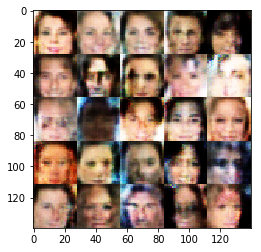

Epoch 1/1... Batch 2010... Discriminator Loss: 1.0390... Generator Loss: 1.0874...
Epoch 1/1... Batch 2020... Discriminator Loss: 0.8744... Generator Loss: 1.7389...
Epoch 1/1... Batch 2030... Discriminator Loss: 0.6515... Generator Loss: 2.5646...
Epoch 1/1... Batch 2040... Discriminator Loss: 0.7149... Generator Loss: 2.0467...
Epoch 1/1... Batch 2050... Discriminator Loss: 0.7350... Generator Loss: 1.7511...
Epoch 1/1... Batch 2060... Discriminator Loss: 1.3064... Generator Loss: 1.9594...
Epoch 1/1... Batch 2070... Discriminator Loss: 0.8135... Generator Loss: 1.2808...
Epoch 1/1... Batch 2080... Discriminator Loss: 0.7326... Generator Loss: 1.3101...
Epoch 1/1... Batch 2090... Discriminator Loss: 0.5313... Generator Loss: 3.0114...
Epoch 1/1... Batch 2100... Discriminator Loss: 1.1521... Generator Loss: 0.8036...


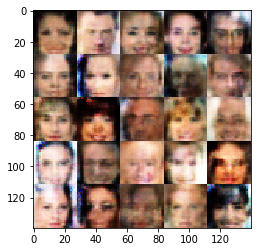

Epoch 1/1... Batch 2110... Discriminator Loss: 0.8697... Generator Loss: 1.3571...
Epoch 1/1... Batch 2120... Discriminator Loss: 1.2437... Generator Loss: 0.9662...
Epoch 1/1... Batch 2130... Discriminator Loss: 0.7717... Generator Loss: 1.2663...
Epoch 1/1... Batch 2140... Discriminator Loss: 0.6891... Generator Loss: 2.7124...
Epoch 1/1... Batch 2150... Discriminator Loss: 0.7365... Generator Loss: 1.6683...
Epoch 1/1... Batch 2160... Discriminator Loss: 0.8199... Generator Loss: 1.5535...
Epoch 1/1... Batch 2170... Discriminator Loss: 0.6146... Generator Loss: 2.0136...
Epoch 1/1... Batch 2180... Discriminator Loss: 1.1008... Generator Loss: 1.0556...
Epoch 1/1... Batch 2190... Discriminator Loss: 0.7198... Generator Loss: 1.7630...
Epoch 1/1... Batch 2200... Discriminator Loss: 0.6850... Generator Loss: 2.4511...


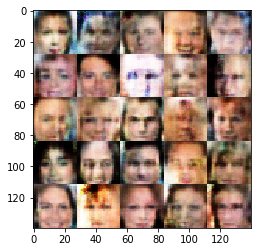

Epoch 1/1... Batch 2210... Discriminator Loss: 0.8657... Generator Loss: 1.4168...
Epoch 1/1... Batch 2220... Discriminator Loss: 0.5242... Generator Loss: 2.4957...
Epoch 1/1... Batch 2230... Discriminator Loss: 0.6658... Generator Loss: 1.6397...
Epoch 1/1... Batch 2240... Discriminator Loss: 0.7622... Generator Loss: 2.6612...
Epoch 1/1... Batch 2250... Discriminator Loss: 0.5819... Generator Loss: 2.3393...
Epoch 1/1... Batch 2260... Discriminator Loss: 0.7612... Generator Loss: 1.4408...
Epoch 1/1... Batch 2270... Discriminator Loss: 1.0402... Generator Loss: 1.5372...
Epoch 1/1... Batch 2280... Discriminator Loss: 1.0082... Generator Loss: 1.0203...
Epoch 1/1... Batch 2290... Discriminator Loss: 1.0133... Generator Loss: 1.1487...
Epoch 1/1... Batch 2300... Discriminator Loss: 0.9117... Generator Loss: 0.9287...


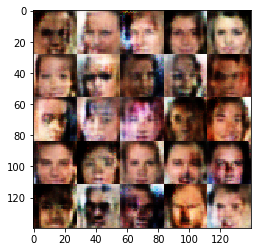

Epoch 1/1... Batch 2310... Discriminator Loss: 1.1320... Generator Loss: 0.7958...
Epoch 1/1... Batch 2320... Discriminator Loss: 0.7643... Generator Loss: 2.9969...
Epoch 1/1... Batch 2330... Discriminator Loss: 0.7423... Generator Loss: 1.6667...
Epoch 1/1... Batch 2340... Discriminator Loss: 0.8131... Generator Loss: 1.1437...
Epoch 1/1... Batch 2350... Discriminator Loss: 0.8970... Generator Loss: 1.0499...
Epoch 1/1... Batch 2360... Discriminator Loss: 0.5568... Generator Loss: 2.3769...
Epoch 1/1... Batch 2370... Discriminator Loss: 1.1379... Generator Loss: 1.4527...
Epoch 1/1... Batch 2380... Discriminator Loss: 0.7613... Generator Loss: 1.6424...
Epoch 1/1... Batch 2390... Discriminator Loss: 0.7059... Generator Loss: 1.8505...
Epoch 1/1... Batch 2400... Discriminator Loss: 0.7910... Generator Loss: 1.9831...


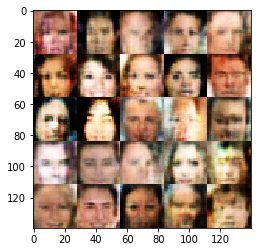

Epoch 1/1... Batch 2410... Discriminator Loss: 1.1693... Generator Loss: 1.2594...
Epoch 1/1... Batch 2420... Discriminator Loss: 0.6320... Generator Loss: 1.7071...
Epoch 1/1... Batch 2430... Discriminator Loss: 0.9070... Generator Loss: 1.2620...
Epoch 1/1... Batch 2440... Discriminator Loss: 0.5150... Generator Loss: 2.3897...
Epoch 1/1... Batch 2450... Discriminator Loss: 0.5676... Generator Loss: 2.1521...
Epoch 1/1... Batch 2460... Discriminator Loss: 1.7205... Generator Loss: 0.3267...
Epoch 1/1... Batch 2470... Discriminator Loss: 0.9190... Generator Loss: 1.2688...
Epoch 1/1... Batch 2480... Discriminator Loss: 1.0311... Generator Loss: 0.9722...
Epoch 1/1... Batch 2490... Discriminator Loss: 0.6020... Generator Loss: 2.7479...
Epoch 1/1... Batch 2500... Discriminator Loss: 0.6392... Generator Loss: 2.2427...


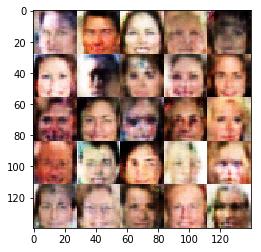

Epoch 1/1... Batch 2510... Discriminator Loss: 0.6927... Generator Loss: 1.4233...
Epoch 1/1... Batch 2520... Discriminator Loss: 0.7139... Generator Loss: 1.8915...
Epoch 1/1... Batch 2530... Discriminator Loss: 0.7539... Generator Loss: 1.3674...
Epoch 1/1... Batch 2540... Discriminator Loss: 0.7906... Generator Loss: 1.8261...
Epoch 1/1... Batch 2550... Discriminator Loss: 0.9004... Generator Loss: 1.5701...
Epoch 1/1... Batch 2560... Discriminator Loss: 0.9395... Generator Loss: 1.8387...
Epoch 1/1... Batch 2570... Discriminator Loss: 0.9330... Generator Loss: 1.1217...
Epoch 1/1... Batch 2580... Discriminator Loss: 1.0141... Generator Loss: 1.1026...
Epoch 1/1... Batch 2590... Discriminator Loss: 1.6379... Generator Loss: 0.3542...
Epoch 1/1... Batch 2600... Discriminator Loss: 0.6783... Generator Loss: 1.7808...


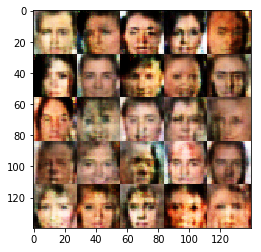

Epoch 1/1... Batch 2610... Discriminator Loss: 0.7348... Generator Loss: 1.7034...
Epoch 1/1... Batch 2620... Discriminator Loss: 0.9795... Generator Loss: 1.4299...
Epoch 1/1... Batch 2630... Discriminator Loss: 0.6350... Generator Loss: 2.3169...
Epoch 1/1... Batch 2640... Discriminator Loss: 0.8660... Generator Loss: 1.0126...
Epoch 1/1... Batch 2650... Discriminator Loss: 0.6188... Generator Loss: 2.2037...
Epoch 1/1... Batch 2660... Discriminator Loss: 0.8453... Generator Loss: 1.3169...
Epoch 1/1... Batch 2670... Discriminator Loss: 0.6087... Generator Loss: 2.4281...
Epoch 1/1... Batch 2680... Discriminator Loss: 1.1301... Generator Loss: 0.9023...
Epoch 1/1... Batch 2690... Discriminator Loss: 0.9235... Generator Loss: 1.0953...
Epoch 1/1... Batch 2700... Discriminator Loss: 0.6191... Generator Loss: 2.0206...


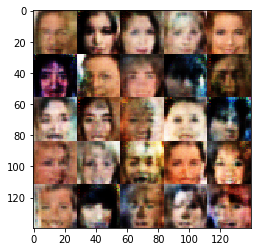

Epoch 1/1... Batch 2710... Discriminator Loss: 1.0952... Generator Loss: 1.0445...
Epoch 1/1... Batch 2720... Discriminator Loss: 0.8890... Generator Loss: 0.9840...
Epoch 1/1... Batch 2730... Discriminator Loss: 0.6871... Generator Loss: 1.9197...
Epoch 1/1... Batch 2740... Discriminator Loss: 0.8716... Generator Loss: 1.3898...
Epoch 1/1... Batch 2750... Discriminator Loss: 0.7885... Generator Loss: 1.8062...
Epoch 1/1... Batch 2760... Discriminator Loss: 0.5171... Generator Loss: 2.4119...
Epoch 1/1... Batch 2770... Discriminator Loss: 0.5578... Generator Loss: 2.1031...
Epoch 1/1... Batch 2780... Discriminator Loss: 1.0166... Generator Loss: 0.8717...
Epoch 1/1... Batch 2790... Discriminator Loss: 0.6483... Generator Loss: 1.7667...
Epoch 1/1... Batch 2800... Discriminator Loss: 1.0087... Generator Loss: 2.0905...


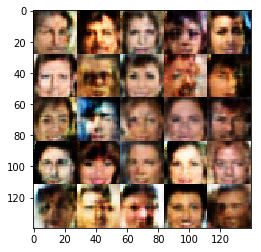

Epoch 1/1... Batch 2810... Discriminator Loss: 0.9362... Generator Loss: 0.9268...
Epoch 1/1... Batch 2820... Discriminator Loss: 0.7095... Generator Loss: 1.7519...
Epoch 1/1... Batch 2830... Discriminator Loss: 1.0763... Generator Loss: 0.9768...
Epoch 1/1... Batch 2840... Discriminator Loss: 0.8206... Generator Loss: 1.2837...
Epoch 1/1... Batch 2850... Discriminator Loss: 0.9400... Generator Loss: 1.1177...
Epoch 1/1... Batch 2860... Discriminator Loss: 0.7209... Generator Loss: 1.8453...
Epoch 1/1... Batch 2870... Discriminator Loss: 0.5588... Generator Loss: 2.0806...
Epoch 1/1... Batch 2880... Discriminator Loss: 0.7229... Generator Loss: 1.4868...
Epoch 1/1... Batch 2890... Discriminator Loss: 1.2864... Generator Loss: 1.1621...
Epoch 1/1... Batch 2900... Discriminator Loss: 0.8948... Generator Loss: 1.1203...


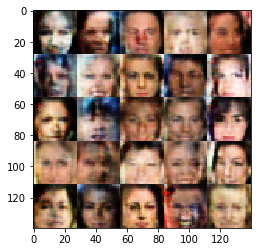

Epoch 1/1... Batch 2910... Discriminator Loss: 0.8688... Generator Loss: 1.5260...
Epoch 1/1... Batch 2920... Discriminator Loss: 0.5078... Generator Loss: 2.6294...
Epoch 1/1... Batch 2930... Discriminator Loss: 0.5925... Generator Loss: 2.0809...
Epoch 1/1... Batch 2940... Discriminator Loss: 0.6052... Generator Loss: 2.8934...
Epoch 1/1... Batch 2950... Discriminator Loss: 0.8127... Generator Loss: 1.6747...
Epoch 1/1... Batch 2960... Discriminator Loss: 0.9541... Generator Loss: 0.8899...
Epoch 1/1... Batch 2970... Discriminator Loss: 1.1253... Generator Loss: 0.7099...
Epoch 1/1... Batch 2980... Discriminator Loss: 0.7425... Generator Loss: 1.6210...
Epoch 1/1... Batch 2990... Discriminator Loss: 0.6307... Generator Loss: 1.9446...
Epoch 1/1... Batch 3000... Discriminator Loss: 0.7311... Generator Loss: 1.6702...


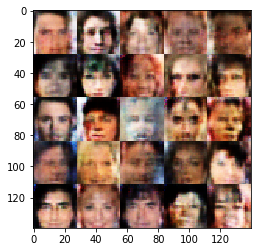

Epoch 1/1... Batch 3010... Discriminator Loss: 1.2097... Generator Loss: 1.4121...
Epoch 1/1... Batch 3020... Discriminator Loss: 0.7235... Generator Loss: 1.4658...
Epoch 1/1... Batch 3030... Discriminator Loss: 0.6097... Generator Loss: 2.3876...
Epoch 1/1... Batch 3040... Discriminator Loss: 0.9468... Generator Loss: 1.4238...
Epoch 1/1... Batch 3050... Discriminator Loss: 0.6771... Generator Loss: 2.1437...
Epoch 1/1... Batch 3060... Discriminator Loss: 1.4192... Generator Loss: 1.5366...
Epoch 1/1... Batch 3070... Discriminator Loss: 0.9306... Generator Loss: 1.0242...
Epoch 1/1... Batch 3080... Discriminator Loss: 0.8739... Generator Loss: 1.5281...
Epoch 1/1... Batch 3090... Discriminator Loss: 0.9828... Generator Loss: 1.1944...
Epoch 1/1... Batch 3100... Discriminator Loss: 0.6128... Generator Loss: 2.6482...


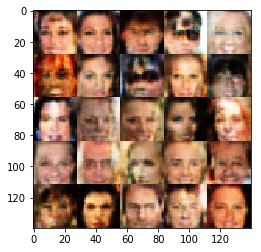

Epoch 1/1... Batch 3110... Discriminator Loss: 0.9792... Generator Loss: 0.9591...
Epoch 1/1... Batch 3120... Discriminator Loss: 0.6528... Generator Loss: 1.9777...
Epoch 1/1... Batch 3130... Discriminator Loss: 0.7141... Generator Loss: 2.1667...
Epoch 1/1... Batch 3140... Discriminator Loss: 1.1759... Generator Loss: 1.6370...
Epoch 1/1... Batch 3150... Discriminator Loss: 0.8460... Generator Loss: 1.1920...
Epoch 1/1... Batch 3160... Discriminator Loss: 0.7527... Generator Loss: 1.4106...


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.